# core

> Fill in a module description here

In [1]:
#| default_exp preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

In [68]:
#| export
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import albumentations as A
import random
import cv2
from fastcore.basics import patch
from fastcore.all import *
#from fastai.vision.all import *
from dataclasses import dataclass, field

from typing import Union, List, Tuple, Optional, Callable, Dict, Any

In [4]:
#| hide
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
#| export
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCS = 5
BATCH_SIZE = 8
BUFFER_SIZE = 30
class_names = ['Pin']
train_count = 107
test_count = 27
num_classes = len(class_names)
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE


In [6]:
#| hide
from nbdev.showdoc import *

In [7]:
path = Path.cwd().parent.parent.parent/'data'#/'data_first/Trainingsdata_1024_1224'
path.ls()

#data_path.ls()

(#2) [Path('/home/hasan/Schreibtisch/projects/Infineon/projects/easy_pin_detection/data/X'),Path('/home/hasan/Schreibtisch/projects/Infineon/projects/easy_pin_detection/data/y')]

In [8]:
#| export
@dataclass
class Preprocess:
    image_path:Union[Path, str]
    label_path:Union[Path, str]
    im_height:int = IMAGE_HEIGHT
    im_width:int = IMAGE_WIDTH
    bf_size:int = BUFFER_SIZE
    bs:int = BATCH_SIZE
    one_channel:bool=False
    test_size:float = 0.2
    img_ext:str = field(default_factory=str, init=False, repr=True)

    def __post_init__(self):
        self.img_ext = Path(self.image_path).ls()[0].suffix
        pat = f'*{self.img_ext}'
        self.images = [str(i) for i in Path(self.image_path).rglob(pat)]
        self.labels = [str(i) for i in Path(self.label_path).rglob(pat)]
        self.train_images, self.test_images, \
            self.train_labels, self.test_labels = train_test_split(
                         self.images,
                         self.labels, 
                         test_size=self.test_size,
                         random_state=42)


In [9]:
preprocess_obj = Preprocess(
                           image_path=path/'X',
                           label_path=path/'y',
                           im_height=IMAGE_HEIGHT,
                           im_width=IMAGE_WIDTH,
                           bs=BATCH_SIZE,
                           one_channel=False
                           )

In [18]:
#| export
@patch_to(Preprocess)
def from_file_to_image(
                       self,
                       im_file:str,
                       one_channel:bool=True
                       ):
    image = tf.io.read_file(im_file)
    image = tf.image.decode_jpeg(image)
    #print(image.shape)
    image = tf.image.resize(
                            image, 
                            (self.im_height, self.im_width, ))
    if one_channel:
        return image
    else:
        return tf.image.grayscale_to_rgb(image)


In [21]:
fn =(path/'X').ls()[0]
fn
test_eq((preprocess_obj.from_file_to_image(str(fn), one_channel=False)).shape, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
test_eq((preprocess_obj.from_file_to_image(str(fn), one_channel=True)).shape, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))

In [23]:
#| export
@patch_to(Preprocess)
def show_image(self,im_file):
    #image = self.from_file_to_image(im_file)
    plt.imshow(im_file)
    plt.axis('off')
    plt.show()

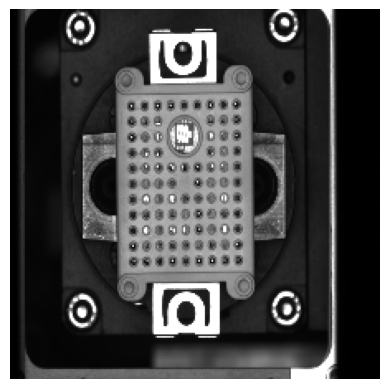

In [24]:
img = preprocess_obj.from_file_to_image(
                                       preprocess_obj.images[0]
    )
preprocess_obj.show_image(img)

In [26]:
#| export
@ patch_to(Preprocess)
def normalize(self, image, min=0):
    def _normalize(im):
        img = tf.cast(im, tf.float32)
        return img / 255.0

    if min == 0:
        return _normalize(image)
    else:
        return (_normalize(image) * 2.0) -1.0

In [27]:
norm_img = preprocess_obj.normalize(img)
np_img_ = norm_img.numpy()
test_eq(np_img_.min(),0.0), test_eq(np_img_.max(),1.0);

In [36]:
#| export
@ patch_to(Preprocess)
def process_image_file(
                       self,
                       im_file:str,
                       norm:bool=True,
                       one_channel=False
                       ):
    image = self.from_file_to_image(im_file, one_channel=one_channel)
    if norm:
        image = self.normalize(image)
    if one_channel:
        image = tf.reshape(image, (self.im_height, self.im_width, 1,))
    else:
        image = tf.reshape(image, (self.im_height, self.im_width, 3,))
    return image

In [39]:
test_eq(preprocess_obj.process_image_file(str(fn), one_channel=False).shape, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
test_eq(preprocess_obj.process_image_file(str(fn), one_channel=True).shape, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))

In [40]:
#| export
@ patch_to(Preprocess)
def process_image_and_label(
                       self,
                       im_file:str,
                       lbl_file:str,
                       norm:bool=True
                       ):
    return self.process_image_file(im_file, norm=norm, one_channel=self.one_channel), self.process_image_file(lbl_file, norm=norm, one_channel=self.one_channel) 

In [57]:
lbl_fn = (path/'y').ls()[0]
pr_img = preprocess_obj.process_image_and_label(
           im_file=str(fn),
           lbl_file=str(lbl_fn),
           norm=True)
test_eq(pr_img[0].shape, (IMAGE_HEIGHT, IMAGE_WIDTH,3)), test_eq(pr_img[1].shape, (IMAGE_HEIGHT,IMAGE_WIDTH, 3));

# Augmentation

In [71]:
@patch_to(Preprocess)
def show_aug(
    self,
    image,
    mask,
    original_image=None,
    original_mask=None
    ):
    
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[0, 0].axis('off')
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[1, 0].axis('off')
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[0, 1].axis('off')

        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        ax[1, 1].axis('off')

In [76]:
@patch_to(Preprocess)
def augementation_(
        self,
        image:tf.Tensor,
        mask:tf.tan,
        IMAGE_HEIGHT:int, 
        IMAGE_WIDTH:int):
    aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=0.5),
        A.PadIfNeeded(min_height=IMAGE_HEIGHT, min_width=IMAGE_WIDTH, p=0.5)
    ], p=1),    
    A.HorizontalFlip(p=0.5),              
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])
    aug_data = aug(image=image.numpy(), mask=mask.numpy())
    image, mask = aug_data['image'], aug_data['mask']
    mask = tf.expand_dims(mask, axis=-1)
    return image, mask

In [77]:
@patch_to(Preprocess)
def read_and_augment(
                    self,
                    image_path,
                    label_path):
    image, mask = self.process_image_and_label(image_path, label_path,norm=self.norm, one_channel=self.one_channel)
    image, mask= self.augementation_(image, mask)
    return image, mask




# Create dataset

In [78]:
#| export
@patch_to(Preprocess)
def create_dataset(
                  self,
                  images, labels,
                  train:bool=True,
                  aug:bool=True
                  ):
    _dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if train:
        if aug:
            _dataset = _dataset.map(read_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
        else:
            _dataset = _dataset.map(
                                self.process_image_and_label, 
                                num_parallel_calls=tf.data.AUTOTUNE
                                )
        return  _dataset\
                   .cache()\
                   .shuffle(
                            self.bf_size,
                            reshuffle_each_iteration=True)\
                   .batch(self.bs)\
                   .repeat()\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        _dataset = _dataset.map(self.process_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
        return  _dataset.batch(self.bs).repeat()


In [79]:
#| export
@patch_to(Preprocess)
def create_train_test_dataset(self):
    self.train_dataset = self.create_dataset(
                                            images=self.train_images, 
                                            labels=self.train_labels,
                                            train=True)
    self.test_dataset = self.create_dataset(
                                           self.test_images,
                                           self.test_labels,
                                           train=False)
    return self.train_dataset, self.test_dataset

In [62]:
#| hide
train_ds, test_ds = preprocess_obj.create_train_test_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [63]:
#| hide
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>

In [64]:
#| export
def foo(): pass

In [65]:
#| hide
import nbdev; nbdev.nbdev_export()